# Objekterkennung IntSys

In diesem Projekt sollen Objekte auf einem Drehteller mithilfe eines Ultraschall Sensors (HCSR04) erkannt werden.

Die gemessenen Daten befinden sich im Unterordner "messdaten"

### Primär orientieren wir uns an der digits-erkennen Übung, und benutzen sklearn

In [76]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.signal import wiener
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report


# Datenformat

Jede log-Datei in den Messdaten besteht aus 10 Umdrehungen.
Zum modellieren, wird die raw data 50/50 geteilt, und anschliessend vorbereitet

Messdateninfos:
Die Messdaten haben jeweils 61 Messpunkte/Umdrehung

In [77]:
directory = "messdaten/"

dose_1 = "logfile_deo_dose_53mm.txt"
dose_2 = "logfile_dose_zweite_messung.txt"
dose_3 = "logfile_dose_dritte_messung.txt"
rubikscube_1 = "logfile_rubicscube_1.txt"
rubikscube_2 = "logfile_rubicscube_zweite_messung.txt"
jbl_1 = "logfile_jbl_speaker.txt"
prisma_1 = "logfile_prisma.txt"

noise = "logfile_empty.txt"

file_list = [
    dose_1,
    dose_2,
    dose_3,
    rubikscube_1,
    rubikscube_2,
    jbl_1,
    prisma_1]

df_noise = pd.read_csv(directory + noise, header=None)

df_list = []

for i in range(len(file_list)):
    temp_df = pd.read_csv(directory + file_list[i], header=None)
    df_list.append(temp_df)

# print(df_list)


In [78]:
def transform_data(df):
    """
    input 305 measurement points, > 5 turns * 61 measurements
    für jeden messpunkt einer drehung die nächsten 61 punkte anhängen
         > ACHTUNG!: nur wenn es 61 oder mehr messpunkte bis zum ende des input df gibt!

         > d.h. es gibt 305 - 61 = 244 output zeilen im df
    """
    # transpose from (n, 1) -> (1, n)
    df_transposed = df
    output_data = []

    for i in range(549): # 244 because 305 - 61 (letzte Umdrehung wird rausgenommen, damit jeder neue teil eine komplette umdrehung hat)
        one_turn = df_transposed.iloc[i:i+61, :]
        # print(one_turn)
        output_data.append(one_turn)
    dfs_reset_index = [df.reset_index(drop=True) for df in output_data]
    result_df = pd.concat(dfs_reset_index, axis=1)
    return result_df.T

In [79]:
def denoise(df_noisy, df_noise):
    # shuffle columns for random permutation
    df_shuffled_noise = df_noise.apply(np.random.permutation)
    df_denoised = df_noisy - df_shuffled_noise
    return df_denoised

In [80]:
df_noise_transformed = transform_data(df_noise)
df_list_transformed = []

label_list = [
    "dose",
    "dose",
    "dose",
    "rubicscube",
    "rubicscube",
    "jbl_speaker",
    "prisma"
    ]


for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
    temp_df_denoised['label'] = label_list[i]
    df_list_transformed.append(temp_df_denoised)
    
df_for_training = pd.concat(df_list_transformed, axis=0)
df_for_training = df_for_training[['label'] + [col for col in df_for_training.columns if col != 'label']]

# print(df_for_training)

In [81]:
y = df_for_training['label']
X = df_for_training.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75 , random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Anzahl der Ausgabeklassen
num_classes = len(label_encoder.classes_)

# Umwandlung der Labels in One-Hot-Encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [82]:
model = Sequential([
                    Dense(64, activation='relu', input_shape=(X_train.shape[1],),),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(num_classes, activation='softmax')  # anzahl der ausgabeneuronen entspricht anzahl der klassen
                    ])

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training des Modells
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical))

#plotten von verlust und genauigkeitskurve

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochen = range(1, len(train_loss) +1)


Epoch 1/50
30/30 [==============================] - 1s 7ms/step - loss: 3.1848 - accuracy: 0.3219 - val_loss: 1.1477 - val_accuracy: 0.5845
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 1.5310 - accuracy: 0.4062 - val_loss: 1.1520 - val_accuracy: 0.6167
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 1.3042 - accuracy: 0.5010 - val_loss: 1.0310 - val_accuracy: 0.6091
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 1.2162 - accuracy: 0.5406 - val_loss: 1.0191 - val_accuracy: 0.6042
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 1.0749 - accuracy: 0.5667 - val_loss: 0.9510 - val_accuracy: 0.6191
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 1.1085 - accuracy: 0.5635 - val_loss: 0.9475 - val_accuracy: 0.6178
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 1.0450 - accuracy: 0.5854 - val_loss: 0.9240 - val_accuracy: 0.6365
Epoch 8/50
30/30 [==

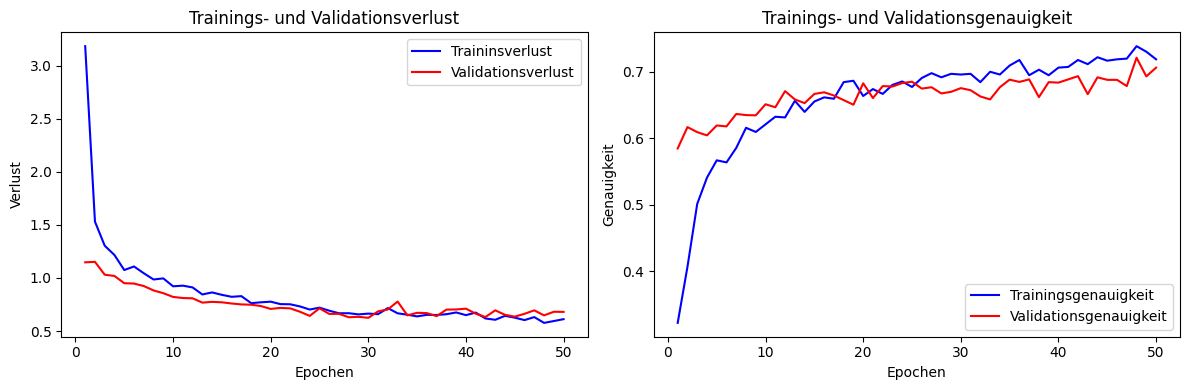

In [83]:
plt.figure(figsize=(12,4))


#verlust plot
plt.subplot(1, 2, 1)
plt.plot(epochen, train_loss, 'b-', label= "Traininsverlust")
plt.plot(epochen, validation_loss, 'r-', label= "Validationsverlust")
plt.title('Trainings- und Validationsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()


#genauigkeit plot
plt.subplot(1,2,2)
plt.plot(epochen, train_accuracy, 'b-', label= "Trainingsgenauigkeit")
plt.plot(epochen, validation_accuracy, 'r-', label= "Validationsgenauigkeit")
plt.title('Trainings- und Validationsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()


plt.tight_layout()
plt.show()

Trainingsgenauigkeit:  0.8125


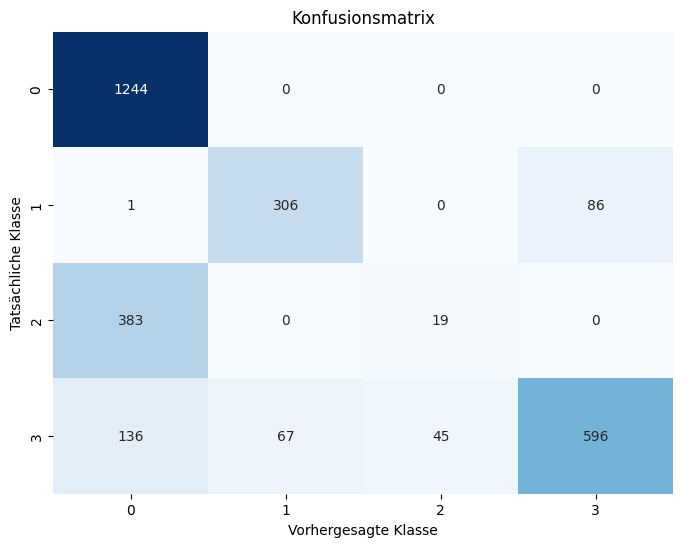

              precision    recall  f1-score   support

        dose       0.71      1.00      0.83      1244
 jbl_speaker       0.82      0.78      0.80       393
      prisma       0.30      0.05      0.08       402
  rubicscube       0.87      0.71      0.78       844

    accuracy                           0.75      2883
   macro avg       0.67      0.63      0.62      2883
weighted avg       0.71      0.75      0.71      2883



In [84]:


model = make_pipeline(StandardScaler(), SVC())

model.fit(X_train, y_train)

# Mache Vorhersagen auf den Trainingsdaten
y_train_pred = model.predict(X_train)

# Berechne die Trainingsgenauigkeit
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Trainingsgenauigkeit: ", train_accuracy)

# Mache Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
# plt.xticks(["dose", "jbl", "prisma", "rubicscube"])
# plt.yticks(["dose", "jbl", "prisma", "rubicscube"])
plt.show()

print(classification_report(y_test, y_pred))


In [85]:

def transform_data_for_prediction(df, expected_num_features):
    """
    Transforms the data for prediction by adding or removing features as needed.
    """
    # Hier fügen Sie Code ein, um die Daten entsprechend zu transformieren, 
    # so dass sie mit den erwarteten Merkmalen des Modells übereinstimmen.
    # Dies kann durch Hinzufügen oder Entfernen von Merkmalen erfolgen.

    # Beispiel: Füllen Sie die fehlenden Merkmale mit Nullen auf, falls erforderlich
    if len(df.columns) < expected_num_features:
        # Füllen Sie die fehlenden Merkmale mit Nullen auf
        num_missing_features = expected_num_features - len(df.columns)
        missing_features = pd.DataFrame(np.zeros((len(df), num_missing_features)))
        df = pd.concat([df, missing_features], axis=1)

    # Beispiel: Reduzieren Sie die Dimensionen der Daten, falls erforderlich
    if len(df.columns) > expected_num_features:
        # Reduzieren Sie die Anzahl der Merkmale auf die erwartete Anzahl
        df = df.iloc[:, :expected_num_features]

    return df

# Verwenden Sie die Funktion, um die Daten für die Vorhersage vorzubereiten
def predict_class_for_file(file_path, model, label_encoder, expected_num_features):
    # Einlesen der Datei
    df = pd.read_csv(file_path, header=None)
    
    # Transformation der Daten
    # df_transformed = transform_data_for_prediction(df, expected_num_features)
    df_transformed = transform_data(df)
    # Vorhersage der Klasse
    predicted_classes = model.predict(df_transformed)
    predicted_labels = label_encoder.inverse_transform(np.argmax(predicted_classes, axis=0))
    
    return predicted_labels

# Verwenden Sie die Funktion, um die Klasse für eine beliebige Datei vorherzusagen
file_path = "messdaten/logfile_rubicscube_zweite_messung.txt"  # Geben Sie hier den Pfad zu Ihrer Datei an
predicted_class = predict_class_for_file(file_path, model, label_encoder, expected_num_features=61)
print("Vorhergesagte Klasse für die Datei:", predicted_class)



ValueError: y should be a 1d array, got an array of shape () instead.